**This analysis explores investment patterns from Shark Tank India using structured EDA. The goal is to understand how funding decisions vary across industries, founders, cities, and valuation expectations. The dataset includes startup financials, founder profiles, deal outcomes, and investor participation. By cleaning the data and building derived metrics such as deal success rate, valuation cuts, and founder-type patterns, the study uncovers signals that influence investor behaviour.
The outputs include pivot tables, visual summaries, and business insights that help explain what drives a successful pitch on the show.**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style and resolution
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150 
plt.rcParams['figure.figsize'] = (10, 6)

### Phase I & II: Data Loading, Cleaning, and Feature Engineering

In [ ]:
# --- Data Loading and Core Feature Engineering ---

In [2]:
df = pd.read_csv(r"C:\Users\umama\Downloads\Shark Tank India.csv")

In [4]:
df.head(5)

,Season Number,Startup Name,Episode Number,Pitch Number,Season Start,Season End,Original Air Date,Episode Title,Anchor,Industry,...,Invested Guest Name,All Guest Names,Namita Present,Vineeta Present,Anupam Present,Aman Present,Peyush Present,Ritesh Present,Amit Present,Guest Present
0,1,BluePineFoods,1,1,20-Dec-21,4-Feb-22,20-Dec-21,Badlegi Business Ki Tasveer,Rannvijay Singh,Food and Beverage,...,Ashneer Grover,Ashneer Grover,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0
1,1,BoozScooters,1,2,20-Dec-21,4-Feb-22,20-Dec-21,Badlegi Business Ki Tasveer,Rannvijay Singh,Vehicles/Electrical Vehicles,...,Ashneer Grover,Ashneer Grover,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0
2,1,HeartUpMySleeves,1,3,20-Dec-21,4-Feb-22,20-Dec-21,Badlegi Business Ki Tasveer,Rannvijay Singh,Beauty/Fashion,...,NaN,Ashneer Grover,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0
3,1,TagzFoods,2,4,20-Dec-21,4-Feb-22,21-Dec-21,"Insaan, Ideas Aur Sapne",Rannvijay Singh,Food and Beverage,...,Ashneer Grover,Ashneer Grover,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0
4,1,HeadAndHeart,2,5,20-Dec-21,4-Feb-22,21-Dec-21,"Insaan, Ideas Aur Sapne",Rannvijay Singh,Children/Education,...,NaN,Ashneer Grover,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0


In [5]:
# Define conversion factor and ALL monetary columns to convert from Lakhs to Millions INR
LAKHS_TO_MILLIONS = 10.0
monetary_cols_lakhs = [
    'Original Ask Amount', 'Valuation Requested', 'Total Deal Amount', 'Deal Valuation', 
    'Yearly Revenue', 'Monthly Sales', 'Gross Margin', 'Net Margin', 'Total Deal Debt',
    'Namita Investment Amount', 'Vineeta Investment Amount', 'Anupam Investment Amount', 
    'Aman Investment Amount', 'Peyush Investment Amount', 'Ritesh Investment Amount', 
    'Amit Investment Amount', 'Guest Investment Amount'
]

In [6]:
# Convert all monetary columns to Millions INR and clean NaNs
for col in monetary_cols_lakhs:
    # Gross/Net Margin are percentages, clean them but don't divide
    if 'Margin' in col:
        df[col] = df[col].replace(-1, np.nan)
    else:
        # Other monetary values are converted to Millions INR
        df[col] = df[col].replace(-1, np.nan).fillna(0)
        df[f'{col}_M_INR'] = df[col] / LAKHS_TO_MILLIONS

In [7]:
# Drop original Lakhs columns (except Margins which were cleaned in place)
df = df.drop(columns=[col for col in monetary_cols_lakhs if 'Margin' not in col], errors='ignore')

In [8]:
# Create Deal Success Flag
df['Deal_Success_Flag'] = np.where(df['Total Deal Amount_M_INR'] > 0, 1, 0)

In [9]:
# Create Founder Type feature (Corrected Logic)
df['Founder_Type'] = 'Other'
df.loc[(df['Male Presenters'].fillna(0) > 0) & (df['Female Presenters'].fillna(0) > 0), 'Founder_Type'] = 'Mixed Team'
df.loc[(df['Male Presenters'].fillna(0) > 0) & (df['Female Presenters'].fillna(0) == 0) & (df['Couple Presenters'] == 0), 'Founder_Type'] = 'Male Team'
df.loc[(df['Male Presenters'].fillna(0) == 0) & (df['Female Presenters'].fillna(0) > 0) & (df['Couple Presenters'] == 0), 'Founder_Type'] = 'Female Team'
df.loc[df['Couple Presenters'] > 0, 'Founder_Type'] = 'Mixed Team'

In [10]:
# Create Industry Cleaned feature
industry_mapping = {
    'Food and Beverage': 'F&B', 'Food & Beverage': 'F&B', 'Health & Wellness': 'Health/Wellness',
    'Technology': 'Tech/Software', 'Software': 'Tech/Software', 'E-commerce': 'E-commerce',
    'Beauty/Cosmetics': 'Beauty/Fashion', 'Fashion/Beauty': 'Beauty/Fashion', 
    'Children/Education': 'Education/Kids', 'Sports/Fitness/Outdoors': 'Fitness/Sports',
    'Sports': 'Fitness/Sports', 'Apparel': 'Beauty/Fashion', 'Home Decor': 'Home/Lifestyle',
    'Lifestyle': 'Home/Lifestyle', 'Home and Kitchen': 'Home/Lifestyle'
}
df['Industry_Cleaned'] = df['Industry'].replace(industry_mapping).str.strip()
top_industries = df['Industry_Cleaned'].value_counts().head(10).index
df['Industry_Cleaned'] = np.where(df['Industry_Cleaned'].isin(top_industries), 
                                  df['Industry_Cleaned'], 'Other')

In [11]:
print("Data Cleaning and Feature Engineering Complete.")
print(df[['Startup Name', 'Industry_Cleaned', 'Deal_Success_Flag', 'Founder_Type', 'Total Deal Amount_M_INR']].head())

Data Cleaning and Feature Engineering Complete.
       Startup Name              Industry_Cleaned  Deal_Success_Flag  \
0     BluePineFoods                           F&B                  1   
1      BoozScooters  Vehicles/Electrical Vehicles                  1   
2  HeartUpMySleeves                Beauty/Fashion                  1   
3         TagzFoods                           F&B                  1   
4      HeadAndHeart                Education/Kids                  0   

  Founder_Type  Total Deal Amount_M_INR  
0   Mixed Team                      7.5  
1    Male Team                      4.0  
2  Female Team                      2.5  
3    Male Team                      7.0  
4   Mixed Team                      0.0  


### Phase III: Business Analytical Questions (Q1-Q8) & Visualizations

In [12]:
# --- Analytical Setup ---
shark_investment_cols_M_INR = [
    'Namita Investment Amount_M_INR', 'Vineeta Investment Amount_M_INR', 
    'Anupam Investment Amount_M_INR', 'Aman Investment Amount_M_INR', 
    'Peyush Investment Amount_M_INR', 'Ritesh Investment Amount_M_INR', 
    'Amit Investment Amount_M_INR'
]
shark_names = ['Namita', 'Vineeta', 'Anupam', 'Aman', 'Peyush', 'Ritesh', 'Amit']

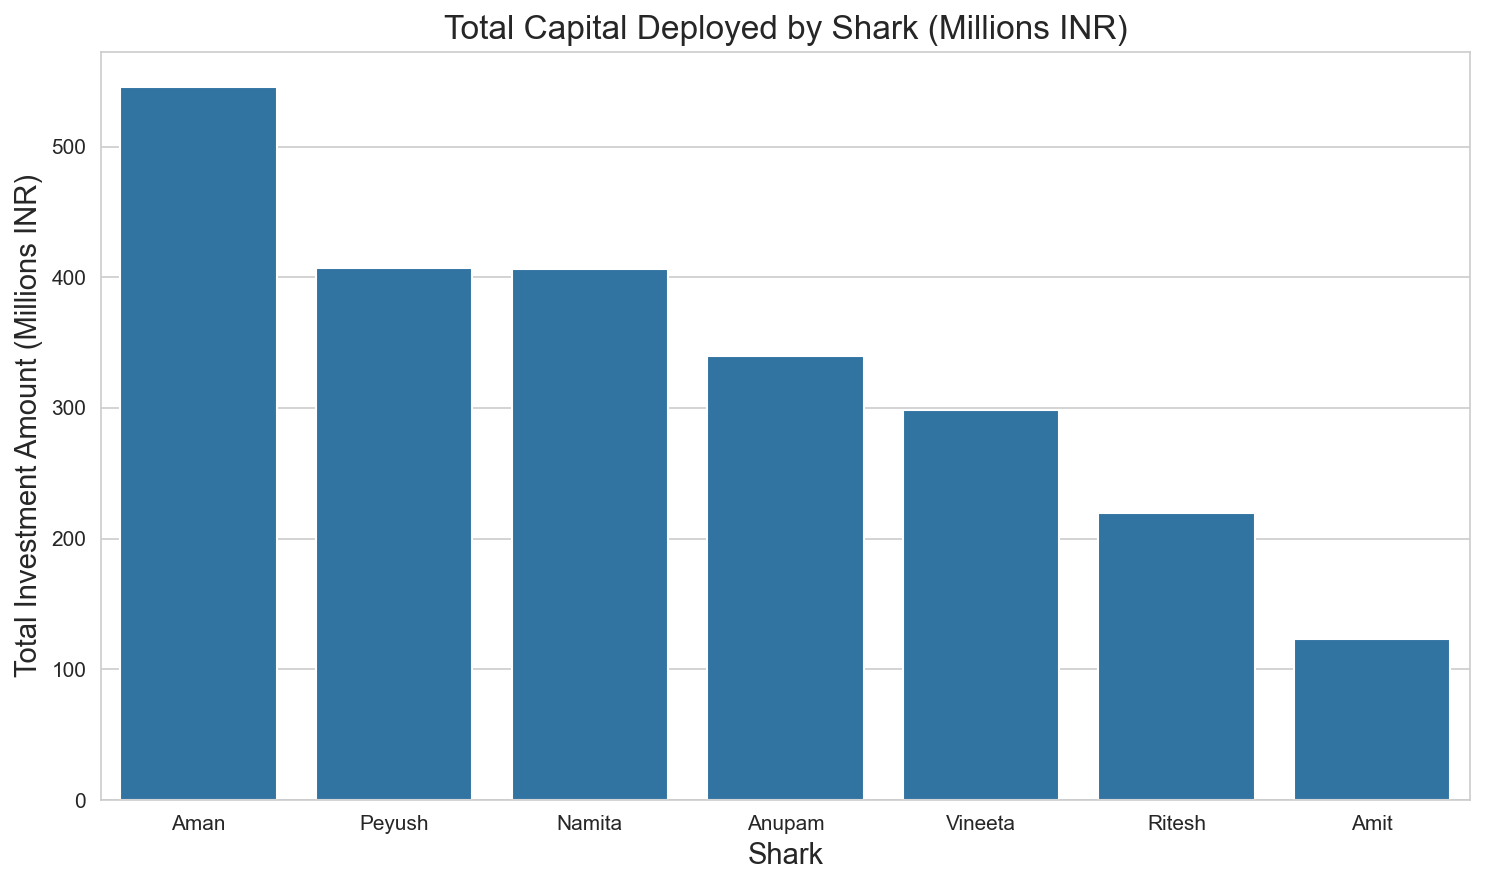

In [17]:
# Total Capital Deployed by Shark & Specialization
shark_investments = {name: df[col].sum() for name, col in zip(shark_names, shark_investment_cols_M_INR)}
investments_series = pd.Series(shark_investments).sort_values(ascending=False)

# Visualization 1: Total Investment by Shark 
plt.figure(figsize=(10, 6))
sns.barplot(x=investments_series.index, y=investments_series.values)
plt.title('Total Capital Deployed by Shark (Millions INR)', fontsize=16)
plt.xlabel('Shark', fontsize=14)
plt.ylabel('Total Investment Amount (Millions INR)', fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

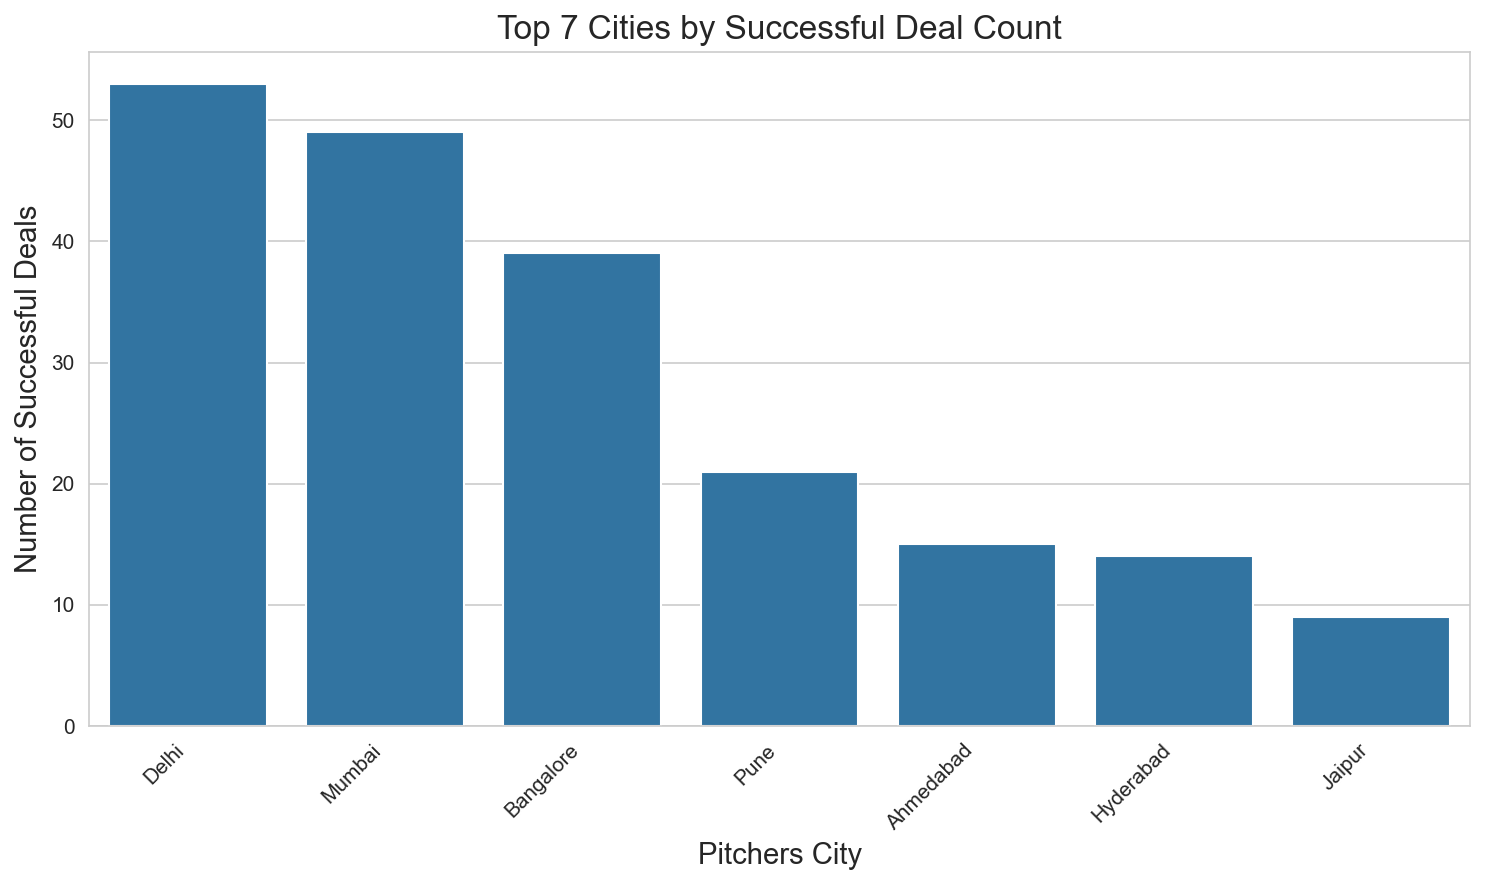

In [15]:
# Q2: Geographic Hotspots (Top 7 Cities)
city_deal_count = df[df['Deal_Success_Flag'] == 1]['Pitchers City'].value_counts().head(7)

# Visualization 2: Deal Count by City 
plt.figure(figsize=(10, 6))
sns.barplot(x=city_deal_count.index, y=city_deal_count.values)
plt.title('Top 7 Cities by Successful Deal Count', fontsize=16)
plt.xlabel('Pitchers City', fontsize=14)
plt.ylabel('Number of Successful Deals', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

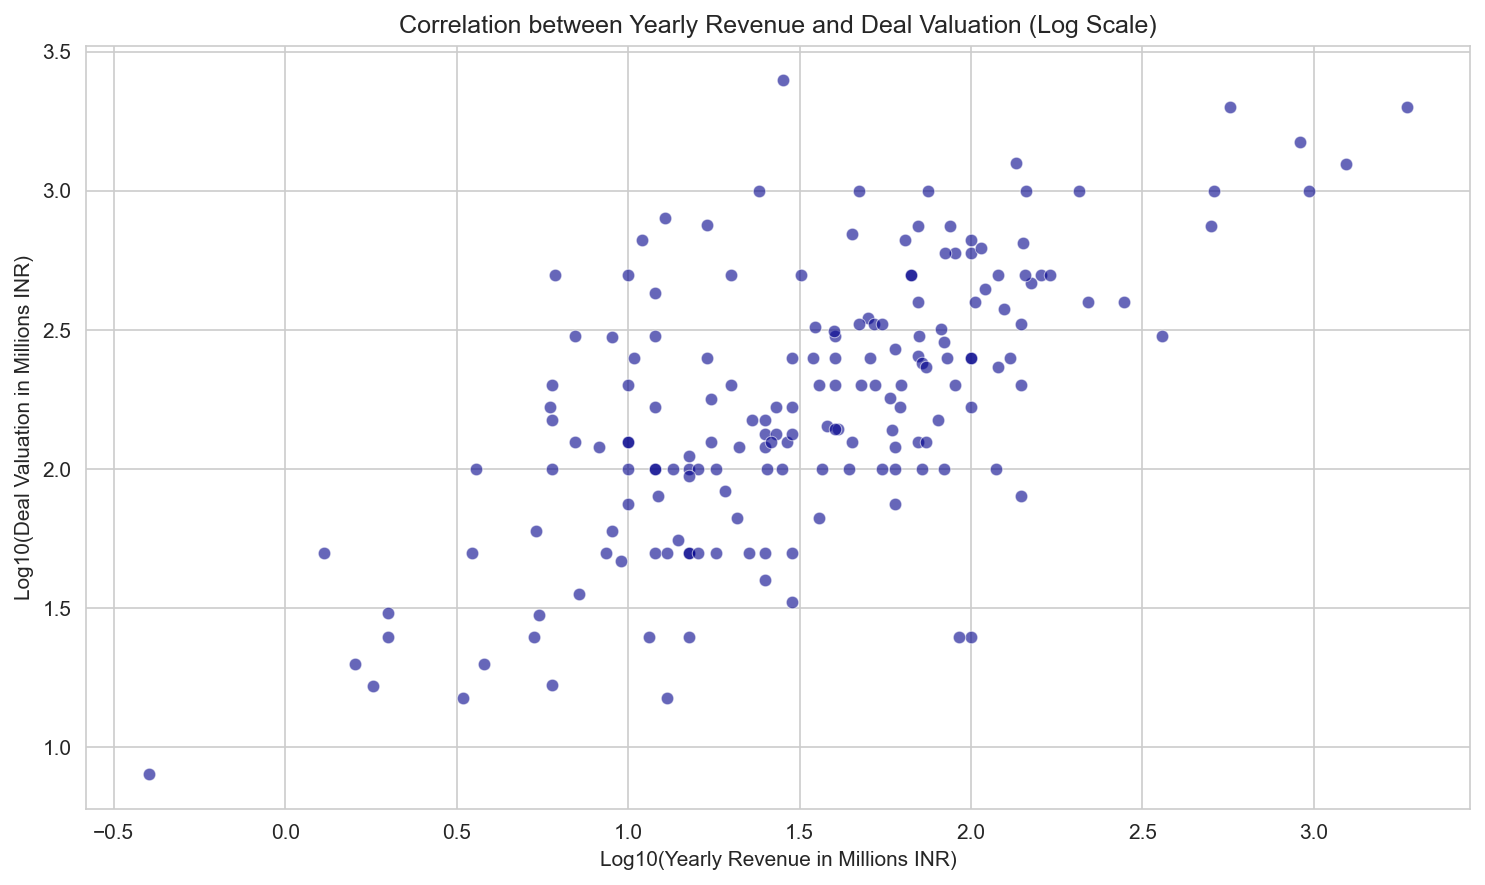

In [18]:
# Q3: Revenue vs. Deal Valuation (Correlation)
revenue_df = df[(df['Deal_Success_Flag'] == 1) & (df['Yearly Revenue_M_INR'] > 0) & (df['Deal Valuation_M_INR'] > 0)].copy()
revenue_df['Log_Revenue'] = np.log10(revenue_df['Yearly Revenue_M_INR'])
revenue_df['Log_Valuation'] = np.log10(revenue_df['Deal Valuation_M_INR'])

# Visualization 3: Revenue vs. Deal Valuation 
plt.figure()
sns.scatterplot(x='Log_Revenue', y='Log_Valuation', data=revenue_df, alpha=0.6, color='darkblue')
plt.title('Correlation between Yearly Revenue and Deal Valuation (Log Scale)')
plt.xlabel('Log10(Yearly Revenue in Millions INR)')
plt.ylabel('Log10(Deal Valuation in Millions INR)')
plt.tight_layout()
plt.show();

In [19]:
# Q4: Founder Type Success Rate (Metric)
founder_success = df.groupby('Founder_Type')['Deal_Success_Flag'].mean().sort_values(ascending=False) * 100
print("\nQ4: Founder Type Deal Success Rates (%):")
print(founder_success)


Q4: Founder Type Deal Success Rates (%):
Founder_Type
Female Team    64.772727
Male Team      55.688623
Mixed Team     54.716981
Name: Deal_Success_Flag, dtype: float64


In [21]:
# Q7: Deal Structure Analysis (Debt/Royalty Trends)
df_deals = df[df['Deal_Success_Flag'] == 1].copy()

# Classify Deal Type
df_deals['Deal_Type'] = np.select(
    [
        (df_deals['Total Deal Debt_M_INR'] > 0) | (df_deals['Royalty Percentage'].fillna(0) > 0),
        (df_deals['Total Deal Equity'].fillna(0) > 0)
    ],
    [
        'Non-Standard (Debt/Royalty)',
        'Equity Only'
    ],
    default='Other/Unknown'
)

# Group types and visualize
plot_counts = df_deals.groupby('Deal_Type')['Startup Name'].count()

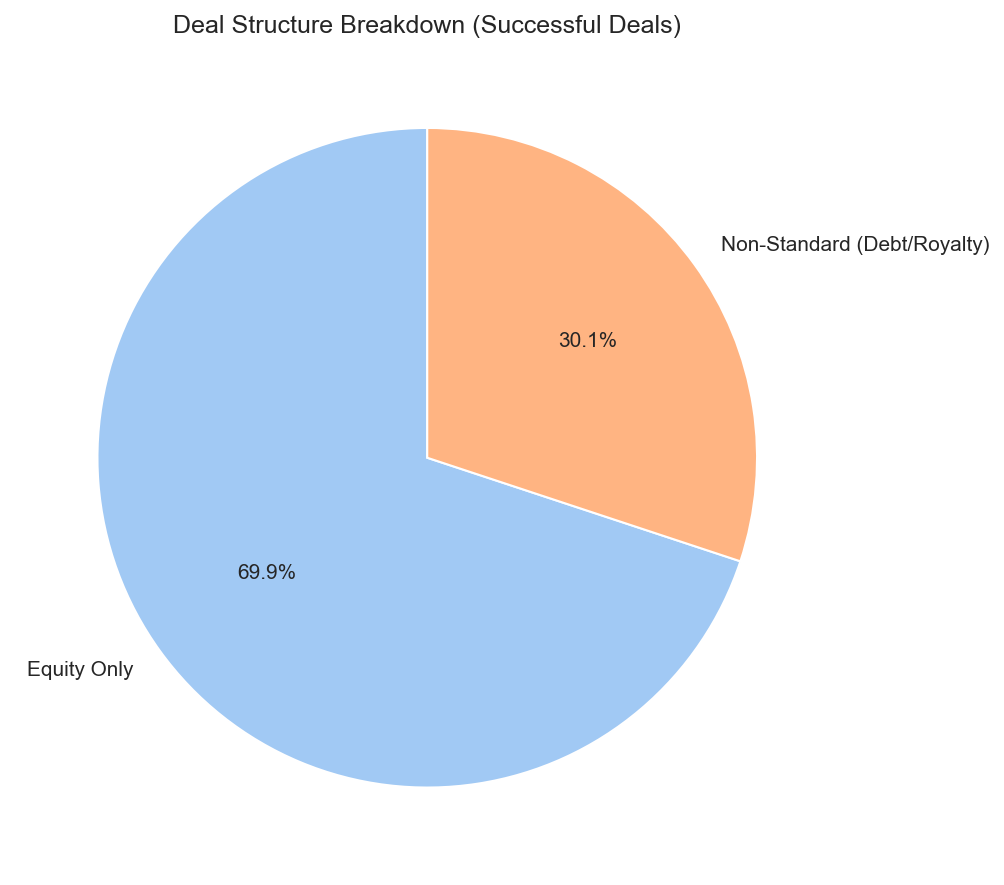

In [22]:
# Visualization 6: Deal Type Distribution 
plt.figure()
plt.pie(plot_counts, labels=plot_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Deal Structure Breakdown (Successful Deals)')
plt.tight_layout()
plt.show();

In [23]:
# Q8: Team Size vs. Success and Negotiation
df_team_filtered = df[df['Number of Presenters'].between(1, 5)].copy()

team_analysis = df_team_filtered.groupby('Number of Presenters').agg(
    Deal_Success_Rate=('Deal_Success_Flag', 'mean'),
    Avg_Deal_Amount=('Total Deal Amount_M_INR', 'mean')
).reset_index()

team_analysis['Deal_Success_Rate'] = team_analysis['Deal_Success_Rate'] * 100

In [28]:
cross_presenters = pd.crosstab(
    df['Number of Presenters'],
    df['Deal_Success_Flag'],
    normalize='index'
) * 100

cross_presenters = cross_presenters.round(1)
cross_presenters

Deal_Success_Flag,0,1
Number of Presenters,,
1,43.0,57.0
2,43.7,56.3
3,40.9,59.1
4,42.9,57.1
5,100.0,0.0
6,100.0,0.0


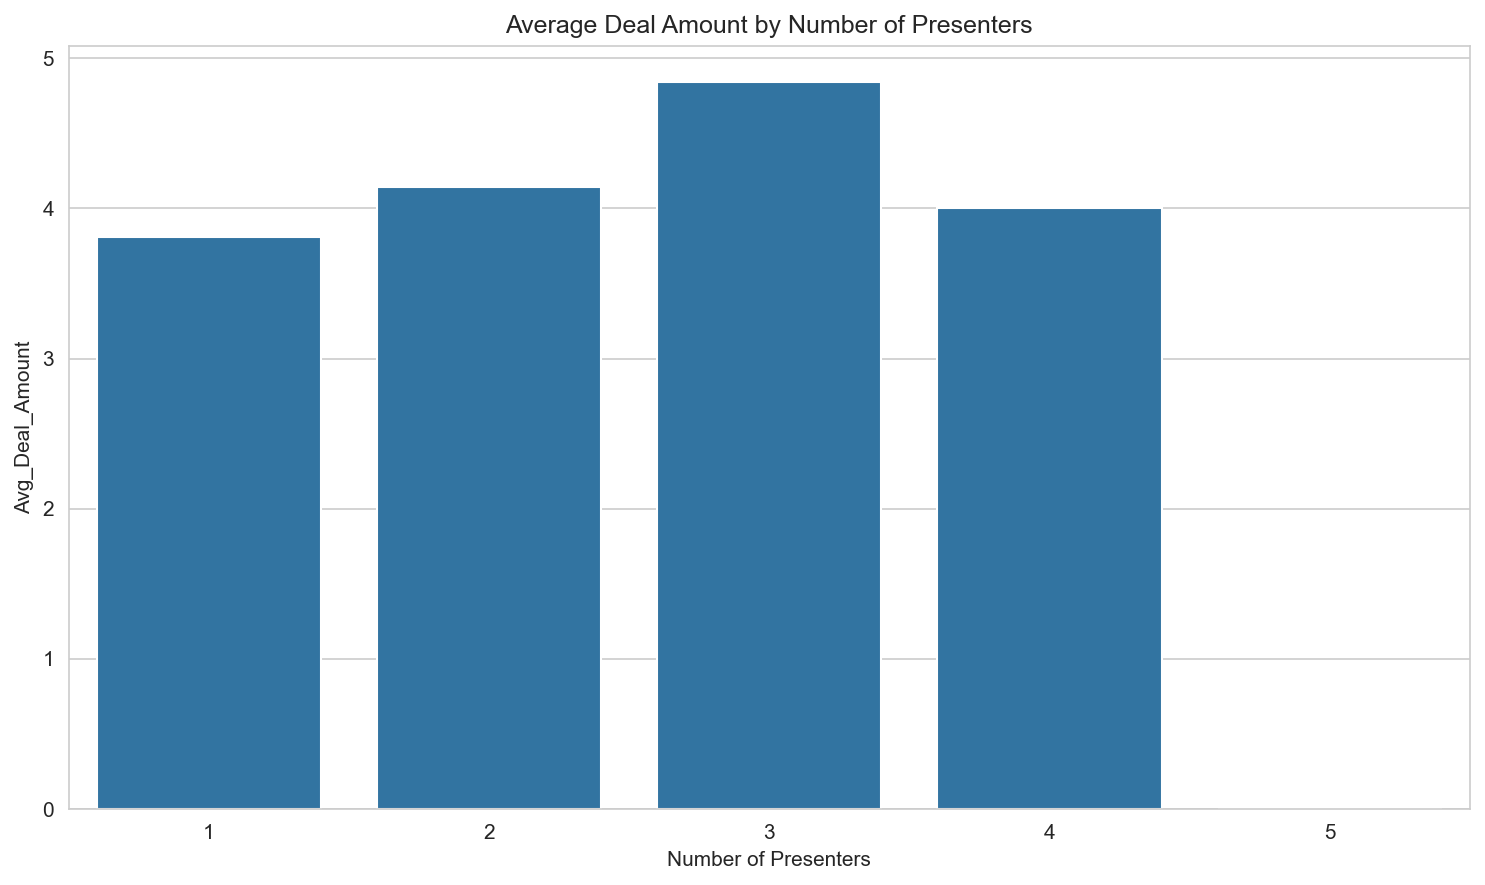

In [30]:
# Visualization 8: Average Deal Amount by Team Size 
plt.figure()
sns.barplot(x='Number of Presenters', y='Avg_Deal_Amount', data=team_analysis)
plt.title('Average Deal Amount by Number of Presenters')
plt.tight_layout()
plt.show();

In [34]:
# List of columns to KEEP in the final analytical dataset
FINAL_COLUMNS = [
    # Identification & Context
    'Season Number', 'Startup Name', 'Industry_Cleaned', 'Pitchers City', 'Pitchers State', 'Pitchers Average Age',
    
    # Financials & Metrics
    'Gross Margin', 'Net Margin', 'Yearly Revenue_M_INR', 'Monthly Sales_M_INR',
    
    # Ask & Deal Details
    'Original Ask Amount_M_INR', 'Valuation Requested_M_INR', 'Total Deal Amount_M_INR', 
    'Deal Valuation_M_INR', 'Total Deal Equity', 'Total Deal Debt_M_INR', 'Royalty Percentage',
    'Number of Sharks in Deal', 'Deal_Success_Flag', 'Received Offer', 'Accepted Offer',
    
    # Team Metrics
    'Number of Presenters', 'Male Presenters', 'Female Presenters', 'Couple Presenters', 'Founder_Type',
    
    # Shark Investment Amounts (for Q1/Q5 Analysis)
    'Namita Investment Amount_M_INR', 'Vineeta Investment Amount_M_INR', 
    'Anupam Investment Amount_M_INR', 'Aman Investment Amount_M_INR', 
    'Peyush Investment Amount_M_INR', 'Ritesh Investment Amount_M_INR', 
    'Amit Investment Amount_M_INR', 'Guest Investment Amount_M_INR'
]

In [35]:
# Create the final, concise analytical DataFrame
df_final_concise = df[FINAL_COLUMNS].copy()

# Export for Power BI
output_file_concise = 'SharkTank_India_Final_Concise.csv'
df_final_concise.to_csv(output_file_concise, index=False)

print(f"Final concise DataFrame exported with {df_final_concise.shape[1]} columns: {output_file_concise}")

Final concise DataFrame exported with 34 columns: SharkTank_India_Final_Concise.csv
